# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 7 - Export for deployment a PyTorch ResNet152 convolutional neural network (CNN) trained for bird species classification.

This notebook shows how to export the trained PyTorch Convolutional Neural Network using the CUB-200-2011 database of birds, so that it can be more easily deployed in a chosen environment. [ONNX](https://onnx.ai/), or the Open Neural Network Exchange initiative and sets of tools, allows for the exporting of machine learning models from a wide variety of machine learning libraries and source languages, into a common format for execution in the common runtime environment, **onnxruntime**. PyTorch natively supports the exporting of trained models through the ***torch.onnx*** module in the PyTorch distribution, which can then be deployed and run in inference mode on any platform that supports the ONNX runtime environment. It even now possible to train ONNX format models inside the ONNX runtime environment, but here we are focusing on inference, that is prediction mode.

We will take the model that we have developed and trained based on the ResNet152 Torchvision implementation, and convert it into an ONNX model format.
This ONNX file can then be used to run the bird classifier on any desired environment.

![RoadMapImage](../docs/birds_roadmap.png)

This notebook is now going to show: 

    1. How to import our already trained ResNet152 PyTorch model ready for inference.
    
    2. Set up a data loader to grab a batch of images from the test set, for inference, and run the inference using the PyTorch framework.
    
    3. How to export a loaded PyTorch model to disk in the ONNX format.
    
    4. How to load a ONNX model from disk and start an inference session using the ONNX runtime environment.
    
    5. How to run inference using the ONNX model with the same test images, and compare the predictions to the PyTorch results for consistency.
    
Once the ONNX file has been created and verified, it is then possible to use this file within the constructs of another application (for example .net applications) for running inside a desktop based software solution. Or it could be uploaded to cloud services, to form part of a REST api or service which takes bird images as inputs and provides a prediction of species. The possibilities are numerous. 

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

import onnx
import onnxruntime

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

In [2]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

### Runtime setup

In [3]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))
onnx_file = os.path.join(output_dir, 'caltech_birds_{}_model.onnx'.format(model))

## Dataloaders, Device setup and load model

As before, we setup the dataloaders and transformations for feeding into the neural network.

As with the evaluation phase, in this example, we only need to load the test image dataset, as we are loading the pre-trained model from the previous network.

After that we setup the device to be used for computation of the results and we load the trained model, as before a ResNet 152.

In [4]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


## Load Torch model and perform inference with some examples

### Load the model and set to inference mode

The PyTorch pre-trained model is loaded from a PTH file, which is pushed to computation device, in this case a GPU.

We then set the expectation of the model to be inference, so it is only expecting images as an input, with no label data, and will not perform backwards propagation.

In [12]:
# Load the best model from file
torch_model = torch.load(model_file)

# Set model to eval model
torch_model.eval()

Here we are grabbing a mini-batch of 4 images to perform our inference tests on, so we can compare the performance of the Torch and ONNX based models, once we have created and imported the ONNX based model. We are not expecting performance improvements, however we are checking that both versions of the model are producing the same predictions. 

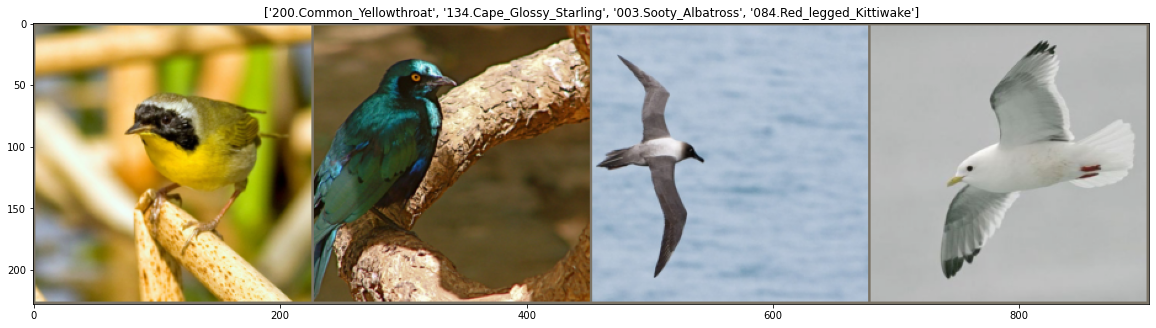

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Perform inference using the PyTorch model

Push the example images to the compute device and perform a prediction using the PyTorch model.

The final step is to compare the prediction of the class with the maximum probability and the true label.

In [13]:
# Push example inputs to device
inputs = inputs.to(device)
classes = classes.to(device)

# Inference
ts1 = time.time()
outputs = torch_model(inputs)
te1 = time.time()

print('TORCH Inference time: {:8.4f} (seconds)'.format(te1-ts1))

TORCH Inference time:   0.0481 (seconds)


In [14]:
for i_example in np.arange(0,outputs.shape[0], 1):
    pred_class = outputs[i_example].argmax().cpu()
    if pred_class == classes[i_example]:
        print('CORRECT PREDICTION')
    else:
        print('!!WRONG PREDICTION!!')
    print('Predicted Label:: {}'.format(class_names[pred_class]))
    print('True Label:: {}'.format(class_names[classes[i_example]]))
    print('')

CORRECT PREDICTION
Predicted Label:: 200.Common_Yellowthroat
True Label:: 200.Common_Yellowthroat

CORRECT PREDICTION
Predicted Label:: 134.Cape_Glossy_Starling
True Label:: 134.Cape_Glossy_Starling

CORRECT PREDICTION
Predicted Label:: 003.Sooty_Albatross
True Label:: 003.Sooty_Albatross

CORRECT PREDICTION
Predicted Label:: 084.Red_legged_Kittiwake
True Label:: 084.Red_legged_Kittiwake



## Export the model to ONNX format.

The next step invokes the ONNX export tools in the ***torch.onnx*** module, which allows for a PyTorch model to be exported to file in the ONNX format for cross-platform, cross-device deployment.

In [ ]:
# Export the model
torch.onnx.export(torch_model,               # model being run
                  inputs,                         # model input (or a tuple for multiple inputs)
                  onnx_file,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}) # variable length axes

## Load the ONNX model and check the inference is correct

Now we have created the ONNX exported model file, we test the conversion process by reading the model back into the notebook, and then running the model with the same images as before, this time using the ONNX runtime environment to execute the ONNX imported model.

After running prediction, we compare the predictions of the ONNX based model with the PyTorch based model and look for any inconsistencies between the model predictions (we are expecting none at all, although it is important to remember we are looking at disparities between the two versions of the model, rather than with the truth).

In [15]:
onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)

In [16]:
ort_session = onnxruntime.InferenceSession(onnx_file)

In [17]:
# compute ONNX Runtime output prediction
ts2 = time.time()
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputs)}
ort_outs = ort_session.run(None, ort_inputs)
te2 = time.time()

print('ONNX Inference time: {:8.4f} (seconds)'.format(te2-ts2))

ONNX Inference time:   0.3597 (seconds)


In [18]:
for i_example in np.arange(0,outputs.shape[0], 1):
    torch_pred_class = outputs[i_example].argmax().cpu()
    onnx_pred_class = ort_outs[0][i_example].argmax()
    
    if torch_pred_class == classes[i_example]:
        print('||   CORRECT PREDICTION')
    else:
        print('||  !!WRONG PREDICTION!!')
        
    if torch_pred_class == onnx_pred_class:
        print('||   TORCH AND ONNX AGREE')
    else:
        print('||  !!TORCH AND ONNX MISMATCH!!')    
    
    print('||   Torch Predicted Label::  {}'.format(class_names[torch_pred_class]))
    print('||   ONNX Predicted Label::   {}'.format(class_names[onnx_pred_class]))
    print('||   True Label::             {}'.format(class_names[classes[i_example]]))
    print('')

||   CORRECT PREDICTION
||   TORCH AND ONNX AGREE
||   Torch Predicted Label::  200.Common_Yellowthroat
||   ONNX Predicted Label::   200.Common_Yellowthroat
||   True Label::             200.Common_Yellowthroat

||   CORRECT PREDICTION
||   TORCH AND ONNX AGREE
||   Torch Predicted Label::  134.Cape_Glossy_Starling
||   ONNX Predicted Label::   134.Cape_Glossy_Starling
||   True Label::             134.Cape_Glossy_Starling

||   CORRECT PREDICTION
||   TORCH AND ONNX AGREE
||   Torch Predicted Label::  003.Sooty_Albatross
||   ONNX Predicted Label::   003.Sooty_Albatross
||   True Label::             003.Sooty_Albatross

||   CORRECT PREDICTION
||   TORCH AND ONNX AGREE
||   Torch Predicted Label::  084.Red_legged_Kittiwake
||   ONNX Predicted Label::   084.Red_legged_Kittiwake
||   True Label::             084.Red_legged_Kittiwake

